In [1]:
import os
import numpy as np
import tensorflow as tf
from utils import sparse_accuracy_ignoring_last_label, sparse_crossentropy_ignoring_last_label, sparse_Mean_IOU
from data_scripts.data_loader import DataLoader
from utils import plot_prediction
from model import DeeplabV3Plus
from tensorflow.keras.optimizers import Adam

In [2]:
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data")
PASCAL_ROOT = os.path.join(DATA_DIR, "VOCdevkit", "VOC2012")
IMGS_PATH = os.path.join(PASCAL_ROOT, "JPEGImages")

SEED = np.random.randint(0, 1000)
IMG_SIZE = (512, 512)
BATCH_SIZE = 1
BUFFER_SIZE = 1000
EPOCHS = 30
CLASSES = 21
RESHAPE_MASKS = True

In [3]:
dataloader_train = DataLoader(
    root_folder=PASCAL_ROOT,
    mode="train",
    image_size=IMG_SIZE,
    channels=(3, 1),
    crop_percent=0.1,
    augment=True,
    compose=False,
    use_berkley=True,
    seed=SEED,
    reshape_masks=RESHAPE_MASKS)

train_generator = dataloader_train.data_batch(batch_size=BATCH_SIZE, shuffle=True)

dataloader_val = DataLoader(
    root_folder=PASCAL_ROOT,
    mode="val",
    image_size=IMG_SIZE,
    channels=(3, 1),
    augment=False,
    compose=False,
    seed=SEED,
    use_berkley=True,
    reshape_masks=RESHAPE_MASKS)

val_generator = dataloader_val.data_batch(batch_size=BATCH_SIZE, shuffle=False)

In [6]:
model = DeeplabV3Plus(
    input_shape=(512, 512, 3), 
    classes=CLASSES, 
    OS=16, 
    last_activation=None, 
    load_weights=True,
    backbone="mobilenet",
    alpha=1.,
    reshape_outputs=RESHAPE_MASKS).build_model(only_DCNN_output=False, only_ASPP_output=False)

In [7]:
for images, masks in val_generator.take(2):
    sample_image, sample_mask = images[0], masks[0]
    if RESHAPE_MASKS:
        sample_mask = tf.reshape(sample_mask, (*IMG_SIZE, 1))

def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    # pred_mask -> [IMG_SIZE, IMG_SIZE, N_CLASS]
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1) # add 1 dim for plotting
    return pred_mask

def print_labels(masks):
    title = ["True Labels: ", "Predicted Labels: "]
    for i in range(2):
        values, count = np.unique(masks[i], return_counts=True)
        print(title[i] + str(dict(zip(values, count))))

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # clear_output(wait=True)
        print(f"Sample Prediction after epoch {epoch + 1}")
        prediction = model.predict(sample_image[tf.newaxis, ...])
        
        if RESHAPE_MASKS:
            prediction = tf.reshape(prediction, (*IMG_SIZE, CLASSES))

        mask = create_mask(prediction)       
        plot_prediction([sample_image, sample_mask, mask], only_prediction=False, show_overlay=True)
        print_labels([sample_mask, mask])

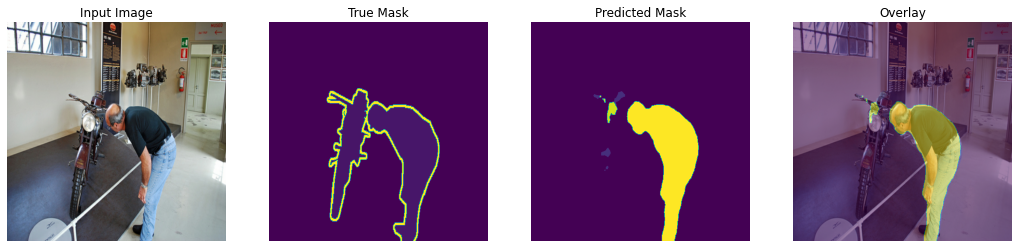

True Labels: {0: 219764, 14: 10959, 15: 22189, 255: 9232}
Predicted Labels: {0: 236714, 2: 795, 14: 698, 15: 23937}


In [8]:
prediction = model.predict(sample_image[tf.newaxis, ...])
prediction = tf.reshape(prediction, (*IMG_SIZE, CLASSES))
mask = create_mask(prediction)
plot_prediction([sample_image, sample_mask, mask], only_prediction=False, show_overlay=True)
print_labels([sample_mask, mask])

In [7]:
losses = sparse_crossentropy_ignoring_last_label
metrics = [sparse_accuracy_ignoring_last_label, sparse_Mean_IOU]
optimizer=Adam(learning_rate=1e-3, epsilon=1e-8, decay=1e-6)

model.compile(optimizer=optimizer, loss=losses, metrics=metrics)

callbacks = [
    DisplayCallback(),
    tf.keras.callbacks.TensorBoard(histogram_freq=1),
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=3, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model_unet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

model_history = model.fit(train_generator, epochs=EPOCHS,
                          validation_data=val_generator,
                          callbacks=callbacks)

Epoch 1/30


C:\Users\Albe\Desktop\DeeplabV3Plus-TF2\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


  10/1464 [..............................] - ETA: 9:14 - loss: 1.6874 - sparse_accuracy_ignoring_last_label: 0.7440 - sparse_Mean_IOU: 0.4433

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Albe\Desktop\DeeplabV3Plus-TF2\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Albe\AppData\Local\Temp/ipykernel_24660/163197879.py", line 17, in <module>
    model_history = model.fit(train_generator, epochs=EPOCHS,
  File "C:\Users\Albe\Desktop\DeeplabV3Plus-TF2\venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\Albe\Desktop\DeeplabV3Plus-TF2\venv\lib\site-packages\keras\engine\training.py", line 1216, in fit
    tmp_logs = self.train_function(iterator)
  File "C:\Users\Albe\Desktop\DeeplabV3Plus-TF2\venv\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\Albe\Desktop\DeeplabV3Plus-TF2\venv\lib\site-packages\tensorflow\python\eager\def_function.py", line 910, in __call

TypeError: object of type 'NoneType' has no len()

In [ ]:
%tensorboard --logdir logs